0:	test: 0.8974525	best: 0.8974525 (0)	total: 1.17s	remaining: 23m 19s
200:	test: 0.9123242	best: 0.9648161 (6)	total: 4m 57s	remaining: 24m 39s
400:	test: 0.9149932	best: 0.9648161 (6)	total: 9m 11s	remaining: 18m 19s
600:	test: 0.9156031	best: 0.9648161 (6)	total: 13m 7s	remaining: 13m 4s
800:	test: 0.9184108	best: 0.9648161 (6)	total: 17m 2s	remaining: 8m 29s
1000:	test: 0.9190441	best: 0.9648161 (6)	total: 20m 39s	remaining: 4m 6s
1199:	test: 0.9190528	best: 0.9648161 (6)	total: 24m 28s	remaining: 0us

bestTest = 0.9648161
bestIteration = 6



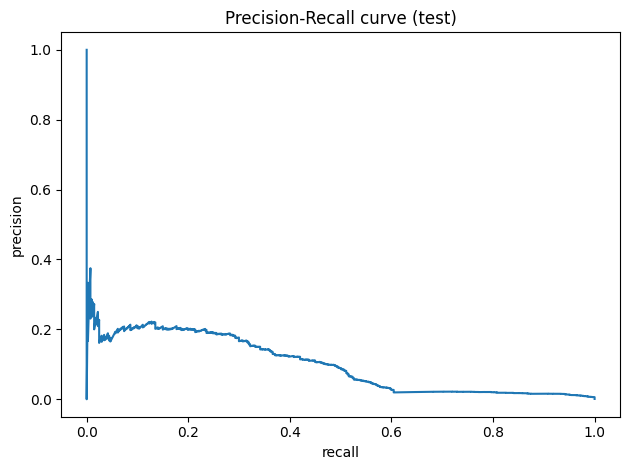

 valid_roc_auc  valid_pr_auc  test_roc_auc  test_pr_auc  best_iteration  test_top0.5pct_recall  test_top0.5pct_k  test_top1.0pct_recall  test_top1.0pct_k
      0.919053      0.069939      0.981232     0.098967               6               0.501229              2340                0.55774              4680
Saved model: ../models/final_catboost_model.cbm
Saved metrics: ../data/processed/final_metrics.csv
Saved artifacts: ../models/training_artifacts.json
Saved PR curve: ../reports/pr_curve.png


In [30]:
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1400)

# Paths
FEATURED_PATH = "../data/processed/iyzico_featured_leakfree.csv"
MODEL_DIR = "../models"
REPORT_DIR = "../reports"

MODEL_PATH = os.path.join(MODEL_DIR, "final_catboost_model.cbm")
ARTIFACT_PATH = os.path.join(MODEL_DIR, "training_artifacts.json")
FEATCOLS_PATH = os.path.join(MODEL_DIR, "feature_columns.json")

METRICS_PATH = "../data/processed/final_metrics.csv"
PR_CURVE_PATH = os.path.join(REPORT_DIR, "pr_curve.png")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

# Config
RANDOM_STATE = 42
TARGET = "is_fraud_transaction"
MISSING_CAT = "MISSING"

BASE_PARAMS = dict(
    iterations=1200,
    depth=8,
    learning_rate=0.01,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=RANDOM_STATE,
    verbose=200,
    allow_writing_files=False,
)

def time_split(df: pd.DataFrame, train_q=0.70, valid_q=0.85):
    # Time-based split: past -> recent -> future
    d = df.sort_values("payment_date").reset_index(drop=True)
    t0 = d["payment_date"].quantile(train_q)
    t1 = d["payment_date"].quantile(valid_q)
    train = d[d["payment_date"] <= t0].copy()
    valid = d[(d["payment_date"] > t0) & (d["payment_date"] <= t1)].copy()
    test  = d[d["payment_date"] > t1].copy()
    return train, valid, test

def topk_recall(y_true: pd.Series, y_score: np.ndarray, top_rate: float):
    n = len(y_true)
    k = max(int(n * top_rate), 1)
    idx = np.argsort(-y_score)[:k]
    denom = max(int(y_true.sum()), 1)
    return float(y_true.iloc[idx].sum() / denom), k

# Load
df = pd.read_csv(FEATURED_PATH, low_memory=False)
df["payment_date"] = pd.to_datetime(df["payment_date"], errors="coerce")
df = df.dropna(subset=["payment_date"]).reset_index(drop=True)
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

train_df, valid_df, test_df = time_split(df)

# Final decision: drop merchant_*date* columns
merchant_date_like = [c for c in df.columns if ("merchant_" in c and "date" in c)]
drop_cols = [TARGET, "payment_date"] + merchant_date_like

# Build matrices
X_train = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns]).copy()
y_train = train_df[TARGET].astype(int)

X_valid = valid_df.drop(columns=[c for c in drop_cols if c in valid_df.columns]).copy()
y_valid = valid_df[TARGET].astype(int)

X_test  = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns]).copy()
y_test  = test_df[TARGET].astype(int)

# Detect categorical columns (stable)
cat_cols = [c for c in X_train.columns if str(X_train[c].dtype) in ["object", "string", "category"]]

# Cast categorical values
for c in cat_cols:
    X_train[c] = X_train[c].astype("string").fillna(MISSING_CAT)
    X_valid[c] = X_valid[c].astype("string").fillna(MISSING_CAT)
    X_test[c]  = X_test[c].astype("string").fillna(MISSING_CAT)

# Cast numeric values
num_cols = [c for c in X_train.columns if c not in cat_cols]
for c in num_cols:
    X_train[c] = pd.to_numeric(X_train[c], errors="coerce")
    X_valid[c] = pd.to_numeric(X_valid[c], errors="coerce")
    X_test[c]  = pd.to_numeric(X_test[c], errors="coerce")

# Class imbalance weight
pos = int(y_train.sum())
neg = int(len(y_train) - pos)
scale_pos_weight = float(neg / max(pos, 1))

# CatBoost wants categorical feature indices (most stable)
cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]

model = CatBoostClassifier(**BASE_PARAMS, scale_pos_weight=scale_pos_weight)

train_pool = Pool(X_train, y_train, cat_features=cat_idx)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_idx)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_idx)


model.fit(train_pool, eval_set=valid_pool, use_best_model=False)
#model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

# Predict
p_valid = model.predict_proba(valid_pool)[:, 1]
p_test  = model.predict_proba(test_pool)[:, 1]

metrics = {
    "valid_roc_auc": float(roc_auc_score(y_valid, p_valid)),
    "valid_pr_auc": float(average_precision_score(y_valid, p_valid)),
    "test_roc_auc": float(roc_auc_score(y_test, p_test)),
    "test_pr_auc": float(average_precision_score(y_test, p_test)),
    "best_iteration": int(model.get_best_iteration() if model.get_best_iteration() is not None else -1),
}
r05, k05 = topk_recall(y_test, p_test, 0.005)
r10, k10 = topk_recall(y_test, p_test, 0.010)
metrics.update({
    "test_top0.5pct_recall": float(r05),
    "test_top0.5pct_k": int(k05),
    "test_top1.0pct_recall": float(r10),
    "test_top1.0pct_k": int(k10),
})

# Save metrics + model
pd.DataFrame([metrics]).to_csv(METRICS_PATH, index=False)
model.save_model(MODEL_PATH)

# Save training artifacts for consistent inference
artifact = {
    "target": TARGET,
    "missing_cat": MISSING_CAT,
    "random_state": RANDOM_STATE,
    "drop_cols": drop_cols,
    "merchant_date_like": merchant_date_like,
    "feature_columns": list(X_train.columns),
    "cat_cols": cat_cols,
    "cat_idx": cat_idx,
    "scale_pos_weight": scale_pos_weight,
    "best_iteration": metrics["best_iteration"],
    "model_params": BASE_PARAMS,
}
with open(ARTIFACT_PATH, "w") as f:
    json.dump(artifact, f, indent=2)
with open(FEATCOLS_PATH, "w") as f:
    json.dump(list(X_train.columns), f, indent=2)

# PR curve plot
prec, rec, _ = precision_recall_curve(y_test, p_test)
plt.figure()
plt.plot(rec, prec)
plt.title("Precision-Recall curve (test)")
plt.xlabel("recall")
plt.ylabel("precision")
plt.tight_layout()
plt.savefig(PR_CURVE_PATH, dpi=150)
plt.show()

print(pd.DataFrame([metrics]).to_string(index=False))
print("Saved model:", MODEL_PATH)
print("Saved metrics:", METRICS_PATH)
print("Saved artifacts:", ARTIFACT_PATH)
print("Saved PR curve:", PR_CURVE_PATH)
